In [1]:
%%bash

mkdir -p turing-gen-data

if ! [ -f svms-data/url.train.svm ]; then
  cp urls-data/all00.svm turing-gen-data/url.train.svm
fi

if ! [ -f svms-data/url.test.svm ]; then
  cp urls-data/all01.svm turing-gen-data/url.test.svm
fi

In [28]:
ks = [1, 2, 3, 4, 5, 6, 8, 10, 12, 14, 16, 18, 20, 22, 25, 30, 35, 40, 50, 100, 150, 200, 300, 400, 500]
ks_str = ' '.join(map(str, ks))
budgets = [1024, 2048, 4096, 8192, 16384]
budgets_str = ' '.join(map(str, budgets))

In [42]:
%%bash -s '{ks_str}' '{budgets_str}'

ks="$1"
budgets="$2"
echo ks $ks
echo budgets $budgets

cd turing-gen-data/

for b in $budgets ; do
for k in $ks ; do
for t in train test ; do 
  ln -s url.${t}.svm url.${t}k${k}b${b}.svm 2> /dev/null || true
done
echo $k $b
done
done | RAYON_NUM_THREADS=4 xargs -L 1 -P $(( $(nproc) / 4 )) bash -c '../csl/target/release/csl \
    --budget $2 \
    --force-filter "$1" --glauber-samples $(( 100 * 1000 * 1000 )) \
    --compress Identity --train url.traink${1}b${2}.svm --max-k 0 \
    --print-new-edges --valid url.testk${1}b${2}.svm > url.k${1}b${2}.log' -s

ks 1 2 3 4 5 6 8 10 12 14 16 18 20 22 25 30 35 40 50 100 150 200 300 400 500
budgets 1024 2048 4096 8192 16384


In [44]:
%%bash -s '{ks_str}'  '{budgets_str}'

ks="$1"
bs="$2"
cd turing-gen-data/


if true ; then

function exarr {
key=$1
value=$(grep "^$key" $2 | head -1)
value=${value#"$key"}
echo "\"$3\":" \""$value"\" ","
}

echo "["

for k in $ks ; do
for b in $bs ; do

logfile="url.k${k}b${b}.log"

echo "{"
echo "\"k\": $k,"
echo "\"budget\": $b,"
#exarr "greedy num colors" $logfile "greedy_colors"
#exarr "filtered thresholded Good-Turing estimate" $logfile "good_turing_new_edge_estimator"
#exarr "filtered thresholded actual new edge avg" $logfile "test_set_new_edges_per_example"
exarr "color collision count" $logfile "greedy_cc"
exarr "color collision std" $logfile "greedy_std"
echo "},"

done
done
echo "]"
# npm install -g relaxed-json
fi | rjson /dev/stdin > extracted-log.json

In [45]:
%%bash
cd turing-gen-data/
 # todo cd at top of this file
head extracted-log.json

[
  {
    "k": 1,
    "budget": 1024,
    "greedy_cc": " 0.31195997991205265",
    "greedy_std": " 0.8065284861537017"
  },
  {
    "k": 1,
    "budget": 2048,


In [46]:
import json
with open('./turing-gen-data/extracted-log.json', 'r') as f:
    r = json.load(f)
import pandas as pd
df = pd.DataFrame.from_records(r)
df['greedy_cc'] = df.greedy_cc.astype(float)
df.head()

,k,budget,greedy_cc,greedy_std
0,1,1024,0.311960,0.8065284861537017
1,1,2048,0.102127,0.4016785261303708
2,1,4096,0.034814,0.21121515946231711
3,1,8192,0.002497,0.058028095761772765
4,1,16384,0.000652,0.026020293010194886


In [47]:
df.budget.unique()

array([ 1024,  2048,  4096,  8192, 16384])

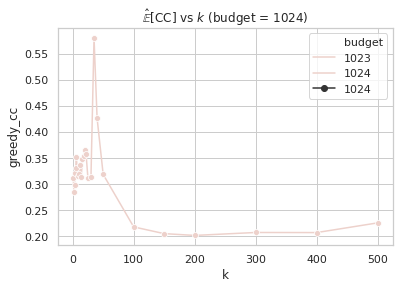

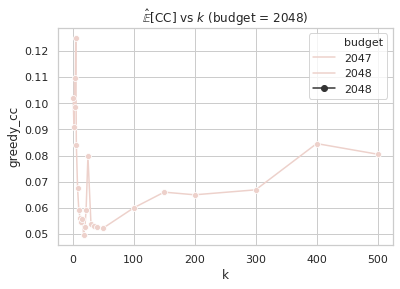

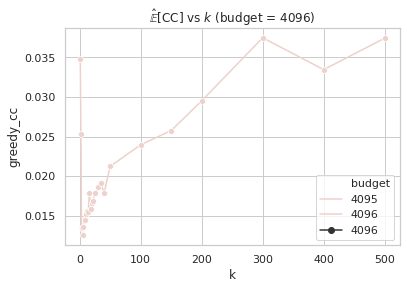

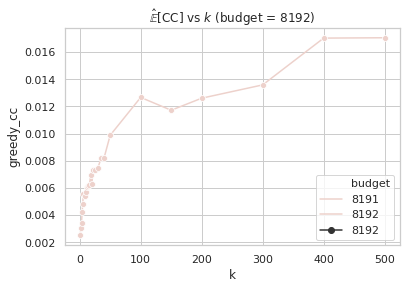

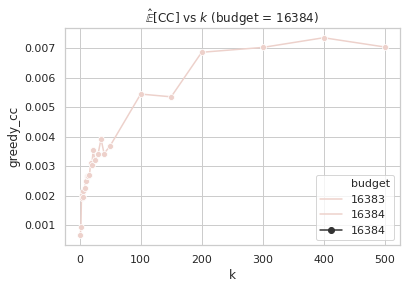

In [53]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")


for budget in df.budget.unique():
    sns.lineplot(data=df[df.budget == budget], x='k', y='greedy_cc', hue='budget', style='budget', markers=True)

    plt.title(r'$\hat\mathbb{{E}}[\mathrm{{CC}}]$ vs $k$ (budget = {})'.format(budget))
    handles, labels = plt.gca().get_legend_handles_labels()
    #plt.savefig('pics/ccgreedy.pdf',  bbox_inches='tight')
    plt.show()

In [ ]:
# TODO then awk transform colliding features to get generalization